In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1. Importing libraries

In [2]:
#import gensim
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from gensim import corpora,models
import pprint
import matplotlib.pyplot as plt
import seaborn as sns
#from gensim.models import CoherenceModel
#import pyLDAvis.gensim
import pickle 
#import pyLDAvis
from scipy.sparse import dok_matrix
from scipy.sparse import csr_matrix, issparse
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 150)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Assigning topics and keywords

In [0]:
terms = {5:['functions','scripting'],
9:['database servers','web layout developement'],
26:['web developement','web frameworks','web servers'],
16: ['database development'],
14: ['search engine','search applications'],
6: ['apps','web design'],
39: ['software developement'],
22: ['data format, login shells','visuals'],
1: ['pc','databases','servers'],
38: ['data','information','security'],
19: ['create','custom','coding','scripting'],
30: ['emails','comments'],
12: ['web frameworks'],
35: ['web frameworks','databases'],
32: ['error','store','loop','directory'],
33: ['databases','dataframes','tables'],
24: ['debugging','testing','time','service'],
11: ['servers','authentication'],
7: ['access','display','session'],
3: ['data structures','website','syntax'],
13: ['web layout','web design','internet'],
27: ['code','remote','source code'],
36: ['iphone','apple','ios','apps'],
29: ['c','object oriented programming'],
18: ['html','web developement','web page','internet'],
31: ['javascript','oracle','event'],
20: ['query','databases'],
8: ['apps','django','web framework'],
0: ['object oriented programming','scripting'],
4: ['string','data type','text','scripting'],
2: ['fies','directory','path','address'],
37: ['api','website','url','authentication'],
15: ['functions','general programming','memory','space'],
25: ['page','c++'],
10: ['blogs','posts','wordpress','domain'],
17: ['base','elements','difference','parse'],
21: ['support','issues','documentation'],
23: ['virtual environment','remote','linux','git','frameworks'],
28: ['programming','web servers'],
34: ['cloud platforms','programming','scripting','databases']}

# 2. Loading data and creating corpus for *training* documents

In [4]:
df = pd.read_csv('/content/drive/My Drive/cleaned_preprocessed_dataset_with_only_nouns_and_title.csv',index_col=0)
df = df.iloc[:100000,:]

#In order to perform LDA, we first need to conver the documents from string format to tokenized format.
df['Title'] = df['Title'].apply(lambda x: str(x).split(' '))

#We now convert the text documents into a dictionary consisting of all unique words in the dataset. The representation consists of each unique word accompanied by a unique ID.
dictionary = corpora.Dictionary(df['Title'])

#Converting the dataset into the bag of words format
corpus = [dictionary.doc2bow(doc) for doc in df['Title']]

df.head()

,Title
0,"[check, image, mime, type]"
1,"[prevent, firefox, press, ctrl-w]"
2,"[r, error, type, list]"
3,"[character, url]"
4,"[contact, detail]"


# 3. Analyze prediction results for *training* documents

In [5]:
df = pd.read_csv('/content/drive/My Drive/document_predictions_100000.csv',index_col=0)
df.head()

,documents,top_topic,topic_dist,keywords
0,"['check', 'image', 'mime', 'type']",15,0.041667,"['functions', 'general programming', 'memory', 'space', 'web frameworks', 'c', 'object oriented programming']"
1,"['prevent', 'firefox', 'press', 'ctrl-w']",32,0.041667,"['error', 'store', 'loop', 'directory', 'web layout', 'web design', 'internet', 'software developement']"
2,"['r', 'error', 'type', 'list']",3,0.041667,"['data structures', 'website', 'syntax', 'functions', 'general programming', 'memory', 'space', 'blogs', 'posts', 'wordpress', 'domain']"
3,"['character', 'url']",3,0.043269,"['data structures', 'website', 'syntax', 'web frameworks', 'databases', 'functions', 'general programming', 'memory', 'space']"
4,"['contact', 'detail']",32,0.043269,"['error', 'store', 'loop', 'directory', 'functions', 'scripting', 'cloud platforms', 'programming', 'scripting', 'databases']"


# 3.1 Topic frequencies in predicted results

In [6]:
topics_freq = pd.DataFrame()
topics_freq['topic'] = df['top_topic'].value_counts().index
topics_freq['freq'] = df['top_topic'].value_counts().values
topics_freq['topic_words'] = list(map(terms.get,topics_freq['topic']))
topics_freq['percent'] = topics_freq['freq']/sum(topics_freq['freq'])
topics_freq = topics_freq.sort_values('freq',ascending=False)
topics_freq.head(10)

,topic,freq,topic_words,percent
0,24,4708,"[debugging, testing, time, service]",0.04708
1,2,4412,"[fies, directory, path, address]",0.04412
2,3,4326,"[data structures, website, syntax]",0.04326
3,15,3747,"[functions, general programming, memory, space]",0.03747
4,29,3556,"[c, object oriented programming]",0.03556
5,5,3168,"[functions, scripting]",0.03168
6,12,3133,[web frameworks],0.03133
7,20,3090,"[query, databases]",0.03090
8,33,2950,"[databases, dataframes, tables]",0.02950
9,31,2900,"[javascript, oracle, event]",0.02900


From the table above, we can see that **topic 24** containing the keywords **debugging, testing, time, service** is the most frequent topic in the model with 4708 documents being tagged with this as the most relevant topic. The other high frequency topics are 2, 3, 15 and 29 with respective frequencies of 4412, 4326, 3747, 3556. 

It is evident that a lot of these top keywords are programming and syntax related which makes sense as Stack Exchange is possibly the best platform for help with coding. One way this information can be leveraged is to quickly bring up similar questions which share similar topics. 

In [7]:
topics_freq.tail(5)

,topic,freq,topic_words,percent
35,4,1600,"[string, data type, text, scripting]",0.01600
36,19,1599,"[create, custom, coding, scripting]",0.01599
37,16,1300,[database development],0.01300
38,23,1089,"[virtual environment, remote, linux, git, frameworks]",0.01089
39,14,800,"[search engine, search applications]",0.00800


The table above shows that the least occurring topic was **topic 14** with a frequency of **800**. This topic contains keywords such as **search engine** and **search applications**. Other low frequency topics contained keywords such as **database developement, virtual environment, remote, linux, git**. 

From this information, we can gauge that these topics are not the most queried on Stack Exchange. Since these words are less queried, these specific questions should be promoted during a search to make them more visible and build up answers for these questions. For frequently occurring topics, it is likely that there are a lot of answers out there. Stack Exchange has a column on the side which lists the most active questions. A similar display can be used for these low occurring topics which would improve visibility. 

Text(0, 0.5, 'Frequency')

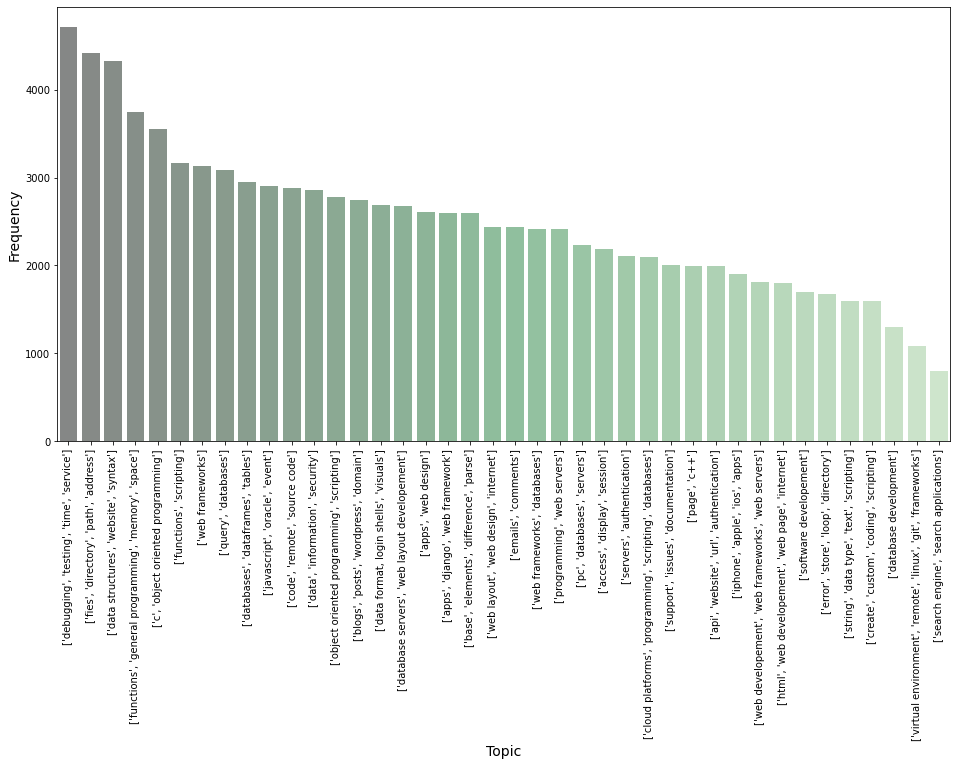

In [8]:
plt.figure(figsize=(16,8))
sns.barplot(x=topics_freq['topic_words'].map(str),y=topics_freq['freq'],alpha=0.6,palette='Greens_d')
plt.xticks(size=10,rotation=90)
plt.yticks(size=10)
plt.xlabel('Topic',size=14)
plt.ylabel('Frequency',size=14)

The plot above shows the distribution of topics for the prediction results. In other words, it's the number of documents each topic appears in. However, a more insightful visualization is shown below where the distributions for the top keywords are displayed. 

# 3.2 Keyword frequencies in predicted results

In [9]:
df = pd.read_csv('/content/drive/My Drive/document_predictions_100000.csv')
df['keywords'] = df['keywords'].apply(lambda x: x.strip('[').strip(']').split(', '))

all_keywords = []
for i in df['keywords']:
  all_keywords.extend(i)

all_keywords = pd.Series(all_keywords)
top_keywords = pd.DataFrame()
top_keywords['word'] = all_keywords.value_counts().index
top_keywords['word'] = top_keywords['word'].apply(lambda x: x.strip("'"))
top_keywords['freq'] = all_keywords.value_counts().values
top_keywords = top_keywords.sort_values('freq',ascending=False)
top_keywords_training = top_keywords
top_keywords_training

,word,freq
0,scripting,48700
1,databases,44486
2,programming,25681
3,web frameworks,20500
4,apps,19969
...,...,...
87,database development,4900
88,web page,4600
89,html,4600
90,search applications,3500


Text(0, 0.5, 'Frequency')

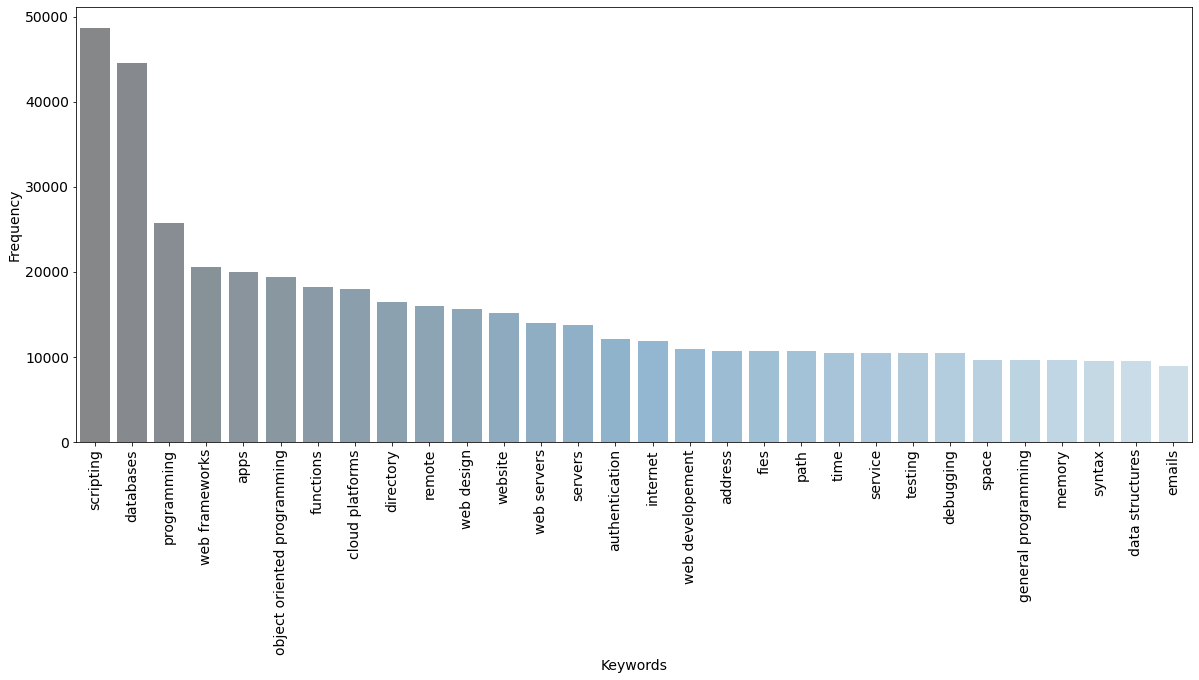

In [10]:
plt.figure(figsize=(20,8))
sns.barplot(x='word',y='freq',data=top_keywords[:30],alpha=0.6,palette='Blues_d')
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.xlabel('Keywords',size=14)
plt.ylabel('Frequency',size=14)

The plot above shows the highest occurring keywords in the predicted results. Terms such as **scripting** (48,700) and **databases** (44,486) were distinctly more prevalent than the others whereas words such as **programming, web frameworks, apps, object oriented programming and functions** were the next highest occurring with frequencies of 25,681, 20,500, 19,969, 19,414 and 18,244 respectively. 

Text(0, 0.5, 'Frequency')

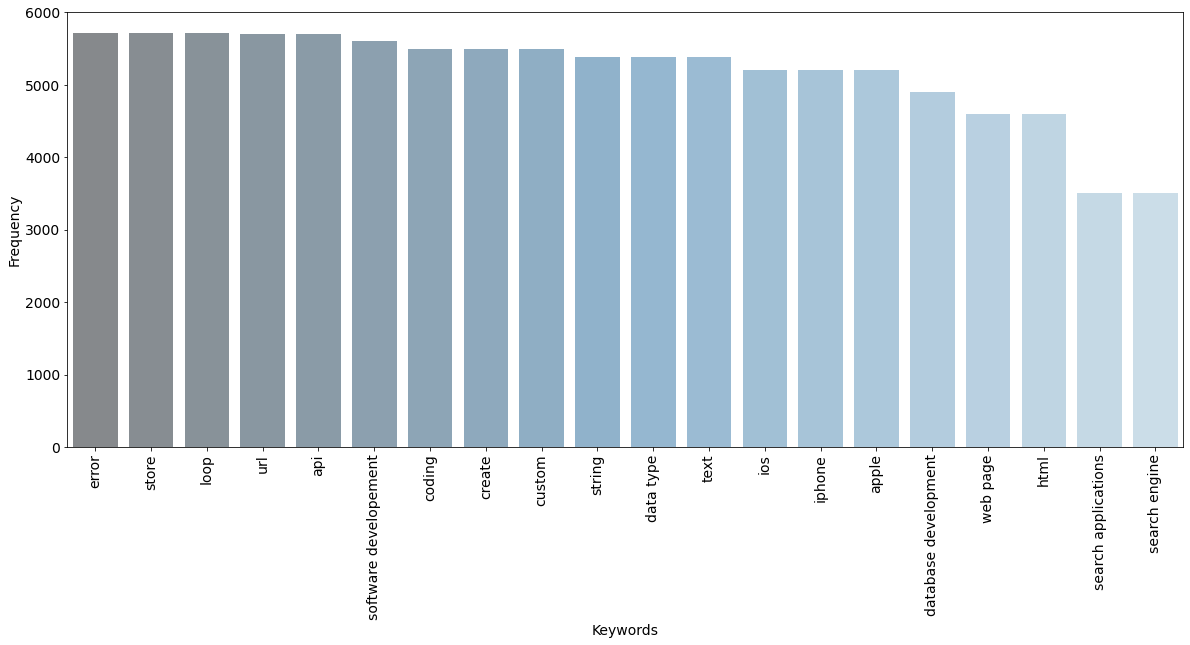

In [11]:
plt.figure(figsize=(20,8))
sns.barplot(x='word',y='freq',data=top_keywords[-20:],alpha=0.6,palette='Blues_d')
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.xlabel('Keywords',size=14)
plt.ylabel('Frequency',size=14)

The plot above shows the lowest occurring terms in the predicted results. Some of these words are string, text, ios, iphone, apple, database developement, html, web page, search applications and search engine. Overall these keywords are mainly related to **text, iphone, html and search engines**. Hence, we can safely say that these are some of the least queried topics on Stack Exchange. 

Some of these actually make sense. For example: 
- People generally don't go to Stack Exchange for debug or troubleshooting questions with regards to the iphone. Other places like CNET or Gear Patrol might be more useful since it's a consumer product. 
- Questions regarding text or string data are not as prevalent as things like syntax, numbers or data structures. 
- While HTML is the foundation of web page deveopement, there are other languages such as JavaScript, CSS, PHP etc. that have become more popular over time. Also, there are frameworks out there to make this process easier. 
- Finally, not a lot of people would need help with search engines unless you are trying to create or simulate one on your own. Even then, creating a search engine is a very niche technical area. 

# 3.3 Find document distribution per topic

In [12]:
df = pd.read_csv('/content/drive/My Drive/document_predictions_100000.csv',index_col=0)
df.head()

,documents,top_topic,topic_dist,keywords
0,"['check', 'image', 'mime', 'type']",15,0.041667,"['functions', 'general programming', 'memory', 'space', 'web frameworks', 'c', 'object oriented programming']"
1,"['prevent', 'firefox', 'press', 'ctrl-w']",32,0.041667,"['error', 'store', 'loop', 'directory', 'web layout', 'web design', 'internet', 'software developement']"
2,"['r', 'error', 'type', 'list']",3,0.041667,"['data structures', 'website', 'syntax', 'functions', 'general programming', 'memory', 'space', 'blogs', 'posts', 'wordpress', 'domain']"
3,"['character', 'url']",3,0.043269,"['data structures', 'website', 'syntax', 'web frameworks', 'databases', 'functions', 'general programming', 'memory', 'space']"
4,"['contact', 'detail']",32,0.043269,"['error', 'store', 'loop', 'directory', 'functions', 'scripting', 'cloud platforms', 'programming', 'scripting', 'databases']"


In [13]:
# Group top 5 sentences under each topic
df_top_doc = pd.DataFrame()
sent_topics_outdf_grpd = df.groupby('top_topic')
for i, grp in sent_topics_outdf_grpd:
    df_top_doc = pd.concat([df_top_doc, 
                                             grp.sort_values(['topic_dist'], ascending=[0]).head(1)], 
                                            axis=0)
# Reset Index    
df_top_doc.reset_index(drop=True, inplace=True)

# Format
#sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
df_top_doc.head(10)

,documents,top_topic,topic_dist,keywords
0,"['news', 'module', 'database', 'kohana']",0,0.075893,"['object oriented programming', 'scripting', 'base', 'elements', 'difference', 'parse', 'page', 'c++']"
1,"['time', 'step', 'probabilities', 'distance', 'wall']",1,0.062500,"['pc', 'databases', 'servers', 'object oriented programming', 'scripting', 'data format, login shells', 'visuals']"
2,"['css3', 'multi', 'column', 'position', 'work']",2,0.061321,"['fies', 'directory', 'path', 'address', 'html', 'web developement', 'web page', 'internet', 'object oriented programming', 'scripting']"
3,"['c', 'whitespace', 'macro', 'name']",3,0.060185,"['data structures', 'website', 'syntax', 'query', 'databases', 'emails', 'comments']"
4,"['split', 'row']",4,0.060184,"['string', 'data type', 'text', 'scripting', 'data', 'information', 'security', 'web frameworks']"
5,"['configure', 'yii', 'framework', 'https']",5,0.059091,"['functions', 'scripting', 'apps', 'web design', 'functions', 'general programming', 'memory', 'space']"
6,"['consequences', 'initialisation', 'pointers']",6,0.061321,"['apps', 'web design', 'pc', 'databases', 'servers', 'query', 'databases']"
7,"['css', 'format', 'a4', 'print']",7,0.080188,"['access', 'display', 'session', 'support', 'issues', 'documentation', 'programming', 'web servers']"
8,"['help', 'hash', 'sha1', 'string']",8,0.061320,"['apps', 'django', 'web framework', 'data format, login shells', 'visuals', 'virtual environment', 'remote', 'linux', 'git', 'frameworks']"
9,"['number', 'desire', 'coordinate', 'matlab']",9,0.061320,"['database servers', 'web layout developement', 'code', 'remote', 'source code', 'cloud platforms', 'programming', 'scripting', 'databases']"


In [14]:
# Number of Documents for Each Topic
topic_counts = df['top_topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_top_doc[['top_topic', 'keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0,"['object oriented programming', 'scripting', 'base', 'elements', 'difference', 'parse', 'page', 'c++']",2778,0.0278
1,1,"['pc', 'databases', 'servers', 'object oriented programming', 'scripting', 'data format, login shells', 'visuals']",2236,0.0224
2,2,"['fies', 'directory', 'path', 'address', 'html', 'web developement', 'web page', 'internet', 'object oriented programming', 'scripting']",4412,0.0441
3,3,"['data structures', 'website', 'syntax', 'query', 'databases', 'emails', 'comments']",4326,0.0433
4,4,"['string', 'data type', 'text', 'scripting', 'data', 'information', 'security', 'web frameworks']",1600,0.0160
5,5,"['functions', 'scripting', 'apps', 'web design', 'functions', 'general programming', 'memory', 'space']",3168,0.0317
6,6,"['apps', 'web design', 'pc', 'databases', 'servers', 'query', 'databases']",2606,0.0261
7,7,"['access', 'display', 'session', 'support', 'issues', 'documentation', 'programming', 'web servers']",2183,0.0218
8,8,"['apps', 'django', 'web framework', 'data format, login shells', 'visuals', 'virtual environment', 'remote', 'linux', 'git', 'frameworks']",2600,0.0260
9,9,"['database servers', 'web layout developement', 'code', 'remote', 'source code', 'cloud platforms', 'programming', 'scripting', 'databases']",2673,0.0267


Text(0, 0.5, 'Frequency')

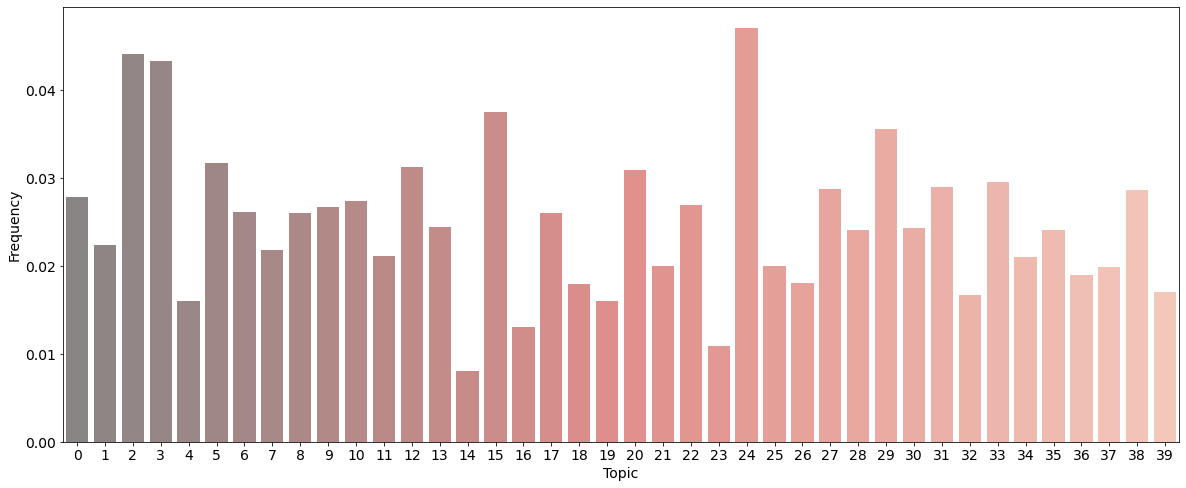

In [15]:
plt.figure(figsize=(20,8))
sns.barplot(x=df_dominant_topics['Dominant_Topic'],y=df_dominant_topics['Perc_Documents'],alpha=0.6,palette='Reds_d')
plt.xticks(size=14)
plt.yticks(size=14)
plt.xlabel('Topic',size=14)
plt.ylabel('Frequency',size=14)

In [16]:
df_dominant_topics_train = df_dominant_topics.sort_values('Dominant_Topic')
df_dominant_topics_train = df_dominant_topics_train.reset_index(drop=True)
df_dominant_topics_train.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0,"['object oriented programming', 'scripting', 'base', 'elements', 'difference', 'parse', 'page', 'c++']",2778,0.0278
1,1,"['pc', 'databases', 'servers', 'object oriented programming', 'scripting', 'data format, login shells', 'visuals']",2236,0.0224
2,2,"['fies', 'directory', 'path', 'address', 'html', 'web developement', 'web page', 'internet', 'object oriented programming', 'scripting']",4412,0.0441
3,3,"['data structures', 'website', 'syntax', 'query', 'databases', 'emails', 'comments']",4326,0.0433
4,4,"['string', 'data type', 'text', 'scripting', 'data', 'information', 'security', 'web frameworks']",1600,0.0160


# 4. Analyze prediction results for *test* documents

In [17]:
df = pd.read_csv('/content/drive/My Drive/cleaned_preprocessed_dataset_with_only_nouns_and_title.csv',index_col=0)
df = df.iloc[100000:200000,:]
df['Title'] = df['Title'].apply(lambda x: str(x).split(' '))
df = df.reset_index(drop=True)

dictionary = corpora.Dictionary(df['Title'])
#Converting the dataset into the bag of words format
corpus = [dictionary.doc2bow(doc) for doc in df['Title']]

df.head()

,Title
0,"[output, value, store, variable, assembly]"
1,[tableviewcontroller]
2,"[need, advice, iphone, app]"
3,"[regex, pattern, contain, space, lead, trail, space]"
4,"[button, ie, browser]"


In [18]:
df_predictions_unseen = pd.read_csv('/content/drive/My Drive/document_predictions_200000.csv',index_col=0)
df_predictions_unseen.head(10)

,documents,top_topic,topic_dist,keywords
0,"['output', 'value', 'store', 'variable', 'assembly']",12,0.040909,"['web frameworks', 'functions', 'general programming', 'memory', 'space', 'c', 'object oriented programming']"
1,['tableviewcontroller'],7,0.044117,"['access', 'display', 'session', 'object oriented programming', 'scripting', 'emails', 'comments']"
2,"['need', 'advice', 'iphone', 'app']",32,0.041667,"['error', 'store', 'loop', 'directory', 'data structures', 'website', 'syntax', 'web layout', 'web design', 'internet']"
3,"['regex', 'pattern', 'contain', 'space', 'lead', 'trail', 'space']",32,0.057018,"['error', 'store', 'loop', 'directory', 'blogs', 'posts', 'wordpress', 'domain', 'data structures', 'website', 'syntax']"
4,"['button', 'ie', 'browser']",11,0.042453,"['servers', 'authentication', 'web frameworks', 'databases', 'html', 'web developement', 'web page', 'internet']"
5,"['time', 'day', 'vim']",22,0.042453,"['data format, login shells', 'visuals', 'data', 'information', 'security', 'string', 'data type', 'text', 'scripting']"
6,"['reuse', 'sqlconnection', 'sqldatareader']",31,0.042453,"['javascript', 'oracle', 'event', 'functions', 'scripting', 'databases', 'dataframes', 'tables']"
7,"['apt-get', '-f', 'install', 'fail', 'dpkg', 'error', 'code']",9,0.057018,"['database servers', 'web layout developement', 'blogs', 'posts', 'wordpress', 'domain', 'apps', 'django', 'web framework']"
8,"['virtualenv', 'libpython']",11,0.043269,"['servers', 'authentication', 'functions', 'general programming', 'memory', 'space', 'web layout', 'web design', 'internet']"
9,"['parameter', 'actionlistener']",27,0.043269,"['code', 'remote', 'source code', 'iphone', 'apple', 'ios', 'apps', 'support', 'issues', 'documentation']"


#4.1 Topic frequencies in test data prediction results

In [19]:
topics_freq = pd.DataFrame()
topics_freq['topic'] = df_predictions_unseen['top_topic'].value_counts().index
topics_freq['freq'] = df_predictions_unseen['top_topic'].value_counts().values
topics_freq['topic_words'] = list(map(terms.get,topics_freq['topic']))
topics_freq['percent'] = topics_freq['freq']/sum(topics_freq['freq'])
topics_freq = topics_freq.sort_values('freq',ascending=False)
topics_freq.head(10)

,topic,freq,topic_words,percent
0,15,7145,"[functions, general programming, memory, space]",0.07145
1,36,6128,"[iphone, apple, ios, apps]",0.06128
2,5,4712,"[functions, scripting]",0.04712
3,30,3677,"[emails, comments]",0.03677
4,4,3579,"[string, data type, text, scripting]",0.03579
5,33,3550,"[databases, dataframes, tables]",0.03550
6,32,3215,"[error, store, loop, directory]",0.03215
7,39,3200,[software developement],0.03200
8,9,3097,"[database servers, web layout developement]",0.03097
9,26,3086,"[web developement, web frameworks, web servers]",0.03086


#4.2 Keyword frequencies in test data prediction results

In [20]:
df_predictions_unseen['keywords'] = df_predictions_unseen['keywords'].apply(lambda x: x.strip('[').strip(']').split(', '))

all_keywords = []
for i in df_predictions_unseen['keywords']:
  all_keywords.extend(i)

all_keywords = pd.Series(all_keywords)
top_keywords = pd.DataFrame()
top_keywords['word'] = all_keywords.value_counts().index
top_keywords['word'] = top_keywords['word'].apply(lambda x: x.strip("'"))
top_keywords['freq'] = all_keywords.value_counts().values
top_keywords = top_keywords.sort_values('freq',ascending=False)
top_keywords_test = top_keywords
top_keywords_test

,word,freq
0,scripting,56800
1,databases,44746
2,programming,24857
3,web frameworks,23000
4,apps,22640
...,...,...
87,information,3900
88,data,3900
89,security,3900
90,search applications,3800


Text(0, 0.5, 'Frequency')

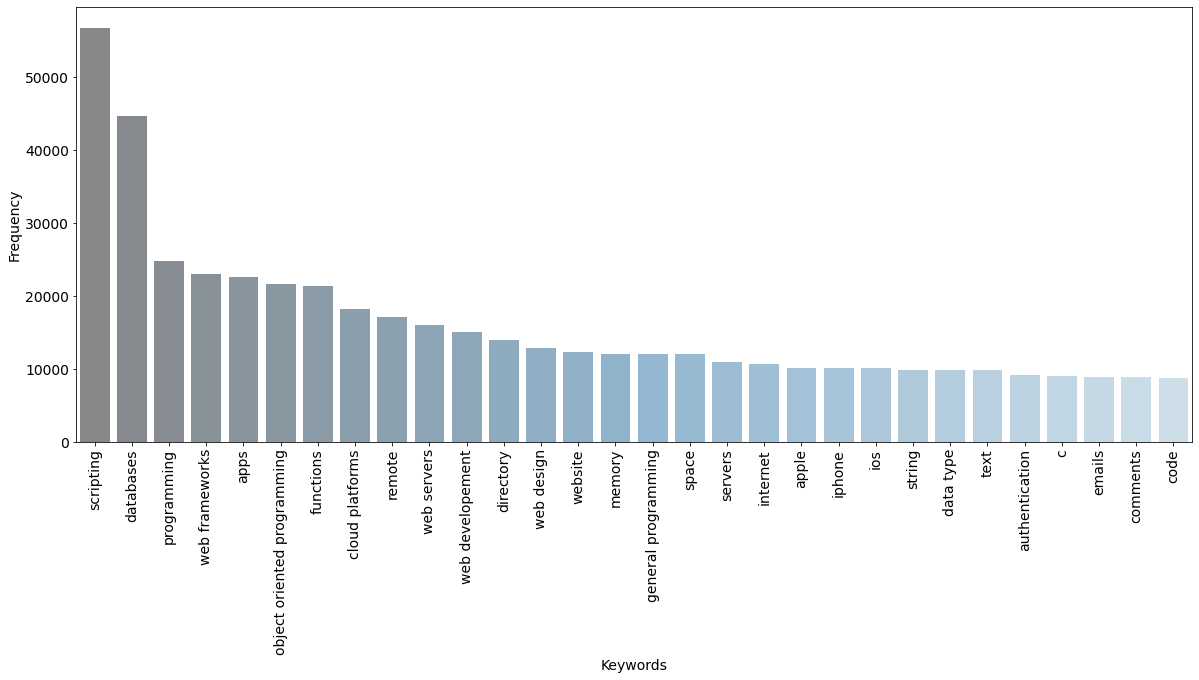

In [21]:
plt.figure(figsize=(20,8))
sns.barplot(x='word',y='freq',data=top_keywords[:30],alpha=0.6,palette='Blues_d')
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.xlabel('Keywords',size=14)
plt.ylabel('Frequency',size=14)

Text(0, 0.5, 'Frequency')

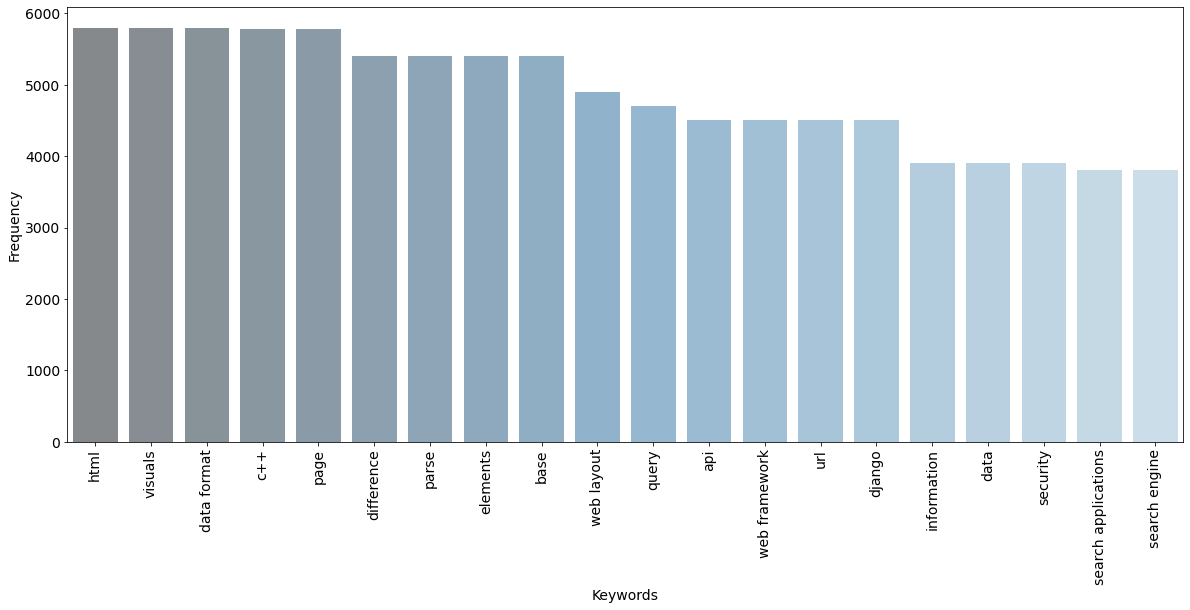

In [22]:
plt.figure(figsize=(20,8))
sns.barplot(x='word',y='freq',data=top_keywords[-20:],alpha=0.6,palette='Blues_d')
plt.xticks(rotation=90,size=14)
plt.yticks(size=14)
plt.xlabel('Keywords',size=14)
plt.ylabel('Frequency',size=14)

In [23]:
#Merging top keywords from train and test prediction results
top_keywords_training = top_keywords_training.reset_index(drop=True)
top_keywords_test = top_keywords_test.reset_index(drop=True)
top_keywords_combined = pd.concat([top_keywords_training,top_keywords_test],axis=1)
top_keywords_combined.columns = ['word_train','freq_train','word_test','freq_test']
top_keywords_combined

,word_train,freq_train,word_test,freq_test
0,scripting,48700,scripting,56800
1,databases,44486,databases,44746
2,programming,25681,programming,24857
3,web frameworks,20500,web frameworks,23000
4,apps,19969,apps,22640
...,...,...,...,...
87,database development,4900,information,3900
88,web page,4600,data,3900
89,html,4600,security,3900
90,search applications,3500,search applications,3800


In [24]:
top_keywords_combined.head(8).sum()

word_train    scriptingdatabasesprogrammingweb frameworksappsobject oriented programmingfunctionscloud platforms
freq_train                                                                                                214994
word_test     scriptingdatabasesprogrammingweb frameworksappsobject oriented programmingfunctionscloud platforms
freq_test                                                                                                 233215
dtype: object

In [25]:
top_keywords_combined.tail(32).sum()

word_train    documentationsupportdisplaysessionaccessdjangoweb frameworkjavascriptoracleeventtablesdataframeserrorstoreloopurlapisoftware developementcodingcre...
freq_train                                                                                                                                                   179347
word_test     pathaddressfiespctestingtimedebuggingservicedatabase serversweb layout developementweb pagelogin shellshtmlvisualsdata formatc++pagedifferencepars...
freq_test                                                                                                                                                    171588
dtype: object

In [26]:
top_keywords_combined.sum()

word_train    scriptingdatabasesprogrammingweb frameworksappsobject oriented programmingfunctionscloud platformsdirectoryremoteweb designwebsiteweb serversserve...
freq_train                                                                                                                                                   884673
word_test     scriptingdatabasesprogrammingweb frameworksappsobject oriented programmingfunctionscloud platformsremoteweb serversweb developementdirectoryweb de...
freq_test                                                                                                                                                    885299
dtype: object

In [27]:
#Merging top keywords from train and test prediction results
top_keywords_training = top_keywords_training.sort_values('word')
top_keywords_training = top_keywords_training.reset_index(drop=True)
top_keywords_test = top_keywords_test.sort_values('word')
top_keywords_test = top_keywords_test.reset_index(drop=True)
top_keywords_combined = pd.concat([top_keywords_training,top_keywords_test],axis=1)
top_keywords_combined.columns = ['word_train','freq_train','word_test','freq_test']
top_keywords_combined

,word_train,freq_train,word_test,freq_test
0,access,6400,access,7700
1,address,10681,address,6600
2,api,5700,api,4500
3,apple,5200,apple,10135
4,apps,19969,apps,22640
...,...,...,...,...
87,web layout developement,7500,web layout developement,6000
88,web page,4600,web page,5800
89,web servers,13981,web servers,15957
90,website,15200,website,12360


In [28]:
#pd.melt(df, id_vars=['A'], value_vars=['B'],
#        var_name='myVarname', value_name='myValname')

temp1 = pd.melt(top_keywords_combined,id_vars=['word_train'],value_vars=['freq_train'],var_name='freq_type',value_name='freq')
temp2 = pd.melt(top_keywords_combined,id_vars=['word_train'],value_vars=['freq_test'],var_name='freq_type',value_name='freq')
temp = pd.concat([temp1,temp2])
temp

,word_train,freq_type,freq
0,access,freq_train,6400
1,address,freq_train,10681
2,api,freq_train,5700
3,apple,freq_train,5200
4,apps,freq_train,19969
...,...,...,...
87,web layout developement,freq_test,6000
88,web page,freq_test,5800
89,web servers,freq_test,15957
90,website,freq_test,12360


Text(0, 0.5, 'Frequency')

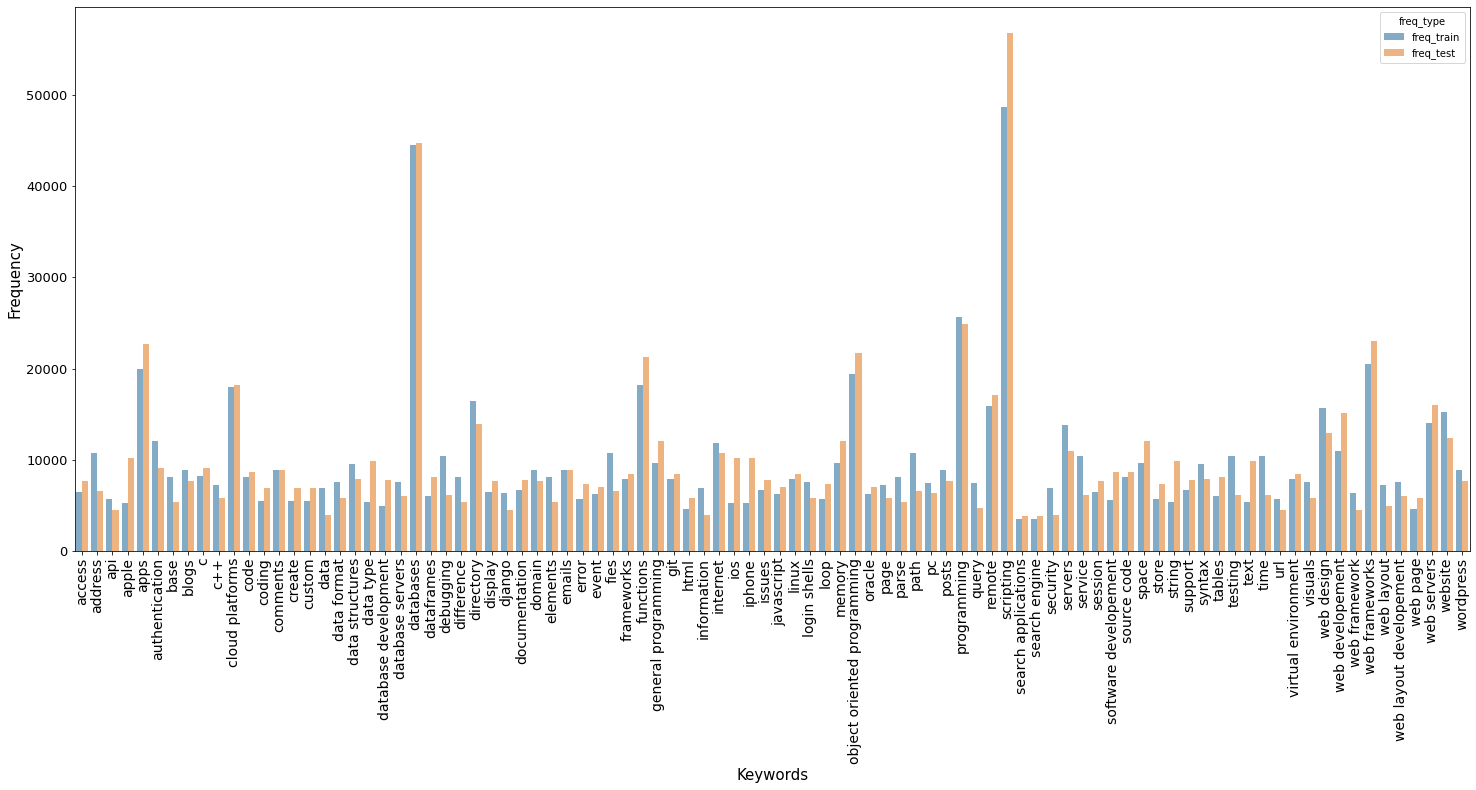

In [29]:
plt.figure(figsize=(25,10))
sns.barplot(data=temp,hue='freq_type',x='word_train',y='freq',alpha=0.6)
plt.xticks(rotation=90,size=14)
plt.yticks(size=13)
plt.xlabel('Keywords',size=15)
plt.ylabel('Frequency',size=15)

#4.3 Document frequencies for each topic in predicted test data

In [30]:
# Group top 5 sentences under each topic
df_top_doc = pd.DataFrame()
sent_topics_outdf_grpd = df_predictions_unseen.groupby('top_topic')
for i, grp in sent_topics_outdf_grpd:
    df_top_doc = pd.concat([df_top_doc, 
                                             grp.sort_values(['topic_dist'], ascending=[0]).head(1)], 
                                            axis=0)
# Reset Index    
df_top_doc.reset_index(drop=True, inplace=True)

# Format
#sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
df_top_doc.head(10)

,documents,top_topic,topic_dist,keywords
0,"['partition', 'windows', 'partition']",0,0.061321,"['object oriented programming', 'scripting', 'iphone', 'apple', 'ios', 'apps', 'c', 'object oriented programming']"
1,"['restrict', 'filesystem', 'access', 'cgi']",1,0.060185,"['pc', 'databases', 'servers', 'base', 'elements', 'difference', 'parse', 'data', 'information', 'security']"
2,"['apostrophe', 'cms', 'engine', 'creation']",2,0.061319,"['fies', 'directory', 'path', 'address', 'javascript', 'oracle', 'event', 'cloud platforms', 'programming', 'scripting', 'databases']"
3,"['java', 'generics', 'pass', 'issue']",3,0.062500,"['data structures', 'website', 'syntax', 'object oriented programming', 'scripting', 'emails', 'comments']"
4,"['declare', 'var', 'roslyn']",4,0.062499,"['string', 'data type', 'text', 'scripting', 'cloud platforms', 'programming', 'scripting', 'databases', 'support', 'issues', 'documentation']"
5,"['data', 'structure', 'okasaki']",5,0.060185,"['functions', 'scripting', 'search engine', 'search applications', 'database development']"
6,"['play', 'video', 'ios', 'center']",6,0.061321,"['apps', 'web design', 'string', 'data type', 'text', 'scripting', 'cloud platforms', 'programming', 'scripting', 'databases']"
7,"['javascript', 'date', 'string', 'age']",7,0.075891,"['access', 'display', 'session', 'software developement', 'databases', 'dataframes', 'tables']"
8,"['query', 'return', 'array']",8,0.059091,"['apps', 'django', 'web framework', 'pc', 'databases', 'servers', 'emails', 'comments']"
9,"['restore', 'page', 'computer', 'boot', 'wiki']",9,0.061321,"['database servers', 'web layout developement', 'object oriented programming', 'scripting', 'emails', 'comments']"


In [31]:
# Number of Documents for Each Topic
topic_counts = df_predictions_unseen['top_topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_top_doc[['top_topic', 'keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0,"['object oriented programming', 'scripting', 'iphone', 'apple', 'ios', 'apps', 'c', 'object oriented programming']",2600,0.0260
1,1,"['pc', 'databases', 'servers', 'base', 'elements', 'difference', 'parse', 'data', 'information', 'security']",2194,0.0219
2,2,"['fies', 'directory', 'path', 'address', 'javascript', 'oracle', 'event', 'cloud platforms', 'programming', 'scripting', 'databases']",1899,0.0190
3,3,"['data structures', 'website', 'syntax', 'object oriented programming', 'scripting', 'emails', 'comments']",2806,0.0281
4,4,"['string', 'data type', 'text', 'scripting', 'cloud platforms', 'programming', 'scripting', 'databases', 'support', 'issues', 'documentation']",3579,0.0358
5,5,"['functions', 'scripting', 'search engine', 'search applications', 'database development']",4712,0.0471
6,6,"['apps', 'web design', 'string', 'data type', 'text', 'scripting', 'cloud platforms', 'programming', 'scripting', 'databases']",2700,0.0270
7,7,"['access', 'display', 'session', 'software developement', 'databases', 'dataframes', 'tables']",3061,0.0306
8,8,"['apps', 'django', 'web framework', 'pc', 'databases', 'servers', 'emails', 'comments']",1290,0.0129
9,9,"['database servers', 'web layout developement', 'object oriented programming', 'scripting', 'emails', 'comments']",3097,0.0310


In [32]:
df_dominant_topics_test = df_dominant_topics.sort_values('Dominant_Topic')
df_dominant_topics_test = df_dominant_topics_test.reset_index(drop=True)
df_dominant_topics_test.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0,"['object oriented programming', 'scripting', 'iphone', 'apple', 'ios', 'apps', 'c', 'object oriented programming']",2600,0.0260
1,1,"['pc', 'databases', 'servers', 'base', 'elements', 'difference', 'parse', 'data', 'information', 'security']",2194,0.0219
2,2,"['fies', 'directory', 'path', 'address', 'javascript', 'oracle', 'event', 'cloud platforms', 'programming', 'scripting', 'databases']",1899,0.0190
3,3,"['data structures', 'website', 'syntax', 'object oriented programming', 'scripting', 'emails', 'comments']",2806,0.0281
4,4,"['string', 'data type', 'text', 'scripting', 'cloud platforms', 'programming', 'scripting', 'databases', 'support', 'issues', 'documentation']",3579,0.0358


In [33]:
df_dominant_topics_combined = pd.concat([df_dominant_topics_train,df_dominant_topics_test],axis=1)
df_dominant_topics_combined.columns = ['dominant_topic_train','topic_keywords_train','num_docs_train','perc_docs_train','dominant_topic_test','topic_keywords_test','num_docs_test','perc_docs_test']
df_dominant_topics_combined

,dominant_topic_train,topic_keywords_train,num_docs_train,perc_docs_train,dominant_topic_test,topic_keywords_test,num_docs_test,perc_docs_test
0,0,"['object oriented programming', 'scripting', 'base', 'elements', 'difference', 'parse', 'page', 'c++']",2778,0.0278,0,"['object oriented programming', 'scripting', 'iphone', 'apple', 'ios', 'apps', 'c', 'object oriented programming']",2600,0.0260
1,1,"['pc', 'databases', 'servers', 'object oriented programming', 'scripting', 'data format, login shells', 'visuals']",2236,0.0224,1,"['pc', 'databases', 'servers', 'base', 'elements', 'difference', 'parse', 'data', 'information', 'security']",2194,0.0219
2,2,"['fies', 'directory', 'path', 'address', 'html', 'web developement', 'web page', 'internet', 'object oriented programming', 'scripting']",4412,0.0441,2,"['fies', 'directory', 'path', 'address', 'javascript', 'oracle', 'event', 'cloud platforms', 'programming', 'scripting', 'databases']",1899,0.0190
3,3,"['data structures', 'website', 'syntax', 'query', 'databases', 'emails', 'comments']",4326,0.0433,3,"['data structures', 'website', 'syntax', 'object oriented programming', 'scripting', 'emails', 'comments']",2806,0.0281
4,4,"['string', 'data type', 'text', 'scripting', 'data', 'information', 'security', 'web frameworks']",1600,0.0160,4,"['string', 'data type', 'text', 'scripting', 'cloud platforms', 'programming', 'scripting', 'databases', 'support', 'issues', 'documentation']",3579,0.0358
5,5,"['functions', 'scripting', 'apps', 'web design', 'functions', 'general programming', 'memory', 'space']",3168,0.0317,5,"['functions', 'scripting', 'search engine', 'search applications', 'database development']",4712,0.0471
6,6,"['apps', 'web design', 'pc', 'databases', 'servers', 'query', 'databases']",2606,0.0261,6,"['apps', 'web design', 'string', 'data type', 'text', 'scripting', 'cloud platforms', 'programming', 'scripting', 'databases']",2700,0.0270
7,7,"['access', 'display', 'session', 'support', 'issues', 'documentation', 'programming', 'web servers']",2183,0.0218,7,"['access', 'display', 'session', 'software developement', 'databases', 'dataframes', 'tables']",3061,0.0306
8,8,"['apps', 'django', 'web framework', 'data format, login shells', 'visuals', 'virtual environment', 'remote', 'linux', 'git', 'frameworks']",2600,0.0260,8,"['apps', 'django', 'web framework', 'pc', 'databases', 'servers', 'emails', 'comments']",1290,0.0129
9,9,"['database servers', 'web layout developement', 'code', 'remote', 'source code', 'cloud platforms', 'programming', 'scripting', 'databases']",2673,0.0267,9,"['database servers', 'web layout developement', 'object oriented programming', 'scripting', 'emails', 'comments']",3097,0.0310


In [34]:
df_dominant_topics_combined

,dominant_topic_train,topic_keywords_train,num_docs_train,perc_docs_train,dominant_topic_test,topic_keywords_test,num_docs_test,perc_docs_test
0,0,"['object oriented programming', 'scripting', 'base', 'elements', 'difference', 'parse', 'page', 'c++']",2778,0.0278,0,"['object oriented programming', 'scripting', 'iphone', 'apple', 'ios', 'apps', 'c', 'object oriented programming']",2600,0.0260
1,1,"['pc', 'databases', 'servers', 'object oriented programming', 'scripting', 'data format, login shells', 'visuals']",2236,0.0224,1,"['pc', 'databases', 'servers', 'base', 'elements', 'difference', 'parse', 'data', 'information', 'security']",2194,0.0219
2,2,"['fies', 'directory', 'path', 'address', 'html', 'web developement', 'web page', 'internet', 'object oriented programming', 'scripting']",4412,0.0441,2,"['fies', 'directory', 'path', 'address', 'javascript', 'oracle', 'event', 'cloud platforms', 'programming', 'scripting', 'databases']",1899,0.0190
3,3,"['data structures', 'website', 'syntax', 'query', 'databases', 'emails', 'comments']",4326,0.0433,3,"['data structures', 'website', 'syntax', 'object oriented programming', 'scripting', 'emails', 'comments']",2806,0.0281
4,4,"['string', 'data type', 'text', 'scripting', 'data', 'information', 'security', 'web frameworks']",1600,0.0160,4,"['string', 'data type', 'text', 'scripting', 'cloud platforms', 'programming', 'scripting', 'databases', 'support', 'issues', 'documentation']",3579,0.0358
5,5,"['functions', 'scripting', 'apps', 'web design', 'functions', 'general programming', 'memory', 'space']",3168,0.0317,5,"['functions', 'scripting', 'search engine', 'search applications', 'database development']",4712,0.0471
6,6,"['apps', 'web design', 'pc', 'databases', 'servers', 'query', 'databases']",2606,0.0261,6,"['apps', 'web design', 'string', 'data type', 'text', 'scripting', 'cloud platforms', 'programming', 'scripting', 'databases']",2700,0.0270
7,7,"['access', 'display', 'session', 'support', 'issues', 'documentation', 'programming', 'web servers']",2183,0.0218,7,"['access', 'display', 'session', 'software developement', 'databases', 'dataframes', 'tables']",3061,0.0306
8,8,"['apps', 'django', 'web framework', 'data format, login shells', 'visuals', 'virtual environment', 'remote', 'linux', 'git', 'frameworks']",2600,0.0260,8,"['apps', 'django', 'web framework', 'pc', 'databases', 'servers', 'emails', 'comments']",1290,0.0129
9,9,"['database servers', 'web layout developement', 'code', 'remote', 'source code', 'cloud platforms', 'programming', 'scripting', 'databases']",2673,0.0267,9,"['database servers', 'web layout developement', 'object oriented programming', 'scripting', 'emails', 'comments']",3097,0.0310


In [35]:
#pd.melt(df, id_vars=['A'], value_vars=['B'],
#        var_name='myVarname', value_name='myValname')

temp1 = pd.melt(df_dominant_topics_combined,id_vars=['dominant_topic_train'],value_vars=['num_docs_train'],var_name='freq_type',value_name='freq')
temp2 = pd.melt(df_dominant_topics_combined,id_vars=['dominant_topic_train'],value_vars=['num_docs_test'],var_name='freq_type',value_name='freq')
temp = pd.concat([temp1,temp2])
temp['keywords'] = list(map(str,list(map(terms.get,temp['dominant_topic_train']))))
temp['keywords'] = temp.apply(lambda x: x[3] + ' - ' + str(x[0]),axis=1)
temp

,dominant_topic_train,freq_type,freq,keywords
0,0,num_docs_train,2778,"['object oriented programming', 'scripting'] - 0"
1,1,num_docs_train,2236,"['pc', 'databases', 'servers'] - 1"
2,2,num_docs_train,4412,"['fies', 'directory', 'path', 'address'] - 2"
3,3,num_docs_train,4326,"['data structures', 'website', 'syntax'] - 3"
4,4,num_docs_train,1600,"['string', 'data type', 'text', 'scripting'] - 4"
...,...,...,...,...
35,35,num_docs_test,2700,"['web frameworks', 'databases'] - 35"
36,36,num_docs_test,6128,"['iphone', 'apple', 'ios', 'apps'] - 36"
37,37,num_docs_test,1879,"['api', 'website', 'url', 'authentication'] - 37"
38,38,num_docs_test,711,"['data', 'information', 'security'] - 38"


Text(0.5, 0, 'Frequency')

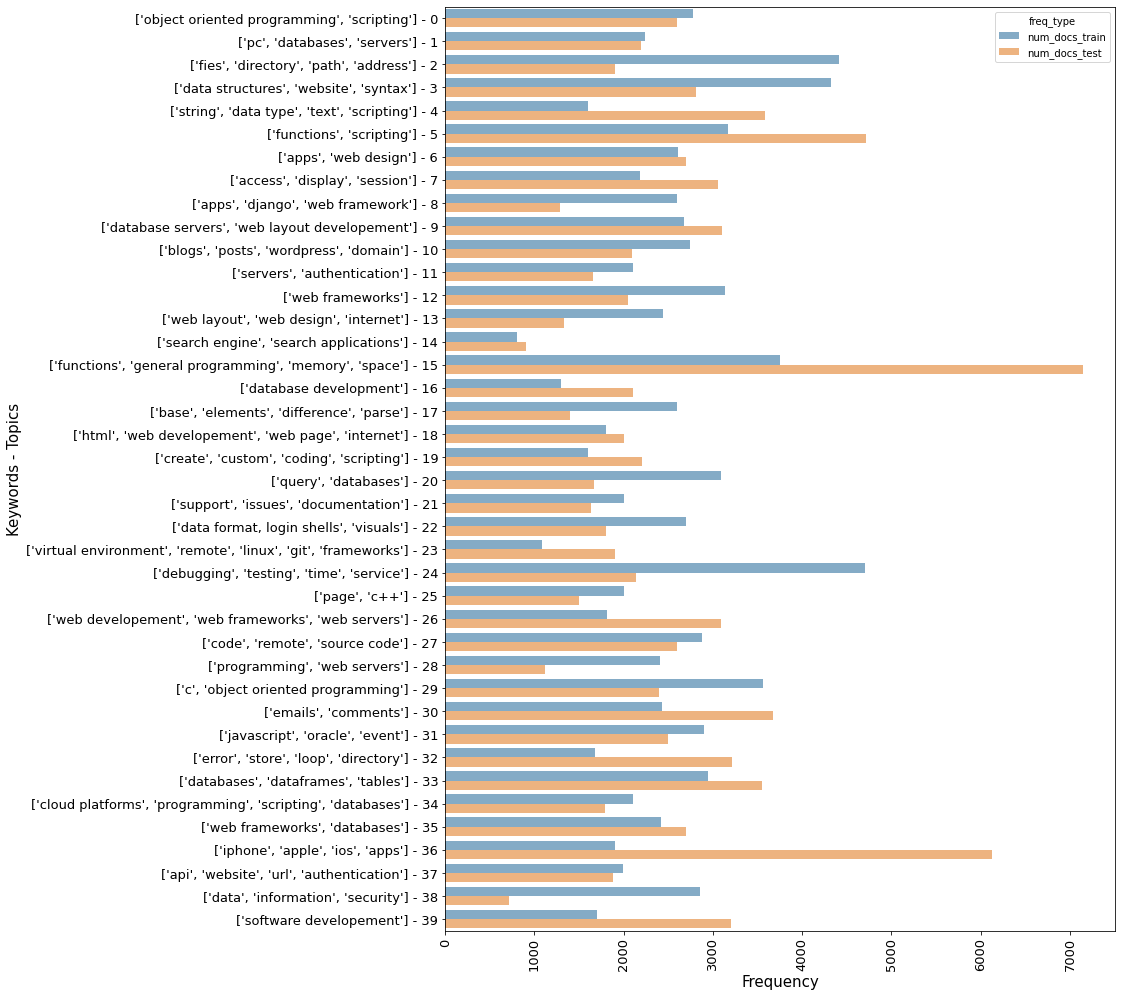

In [36]:
plt.figure(figsize=(12,17))
sns.barplot(data=temp,hue='freq_type',y='keywords',x='freq',alpha=0.6,orient='h')
plt.xticks(rotation=90,size=13)
plt.yticks(size=13)
plt.ylabel('Keywords - Topics',size=15)
plt.xlabel('Frequency',size=15)